CisReg datbase:

* Cis_include_genome2  or Cis_include_mRNA
  * RFXXXX/
    * RFFXXXX.filtered.clustal
    * RFFXXXX.filtered.struct
    * Cis_flanks-XX/
      * ID-SS-EE_known_nt.fasta


Overall Procedure:
For each family:
    1. Read sequences and alignment from RFFXXXX.filtered.clustal
    2. For each pair of sequence compute PSI and SCI. For the PSI, sequences are reliagned but for the SCI Rfam alignmnet is passed to RNAalifold
    3. From pairs with PSI>0.95 only keep one. This is to avoid having too similar alignments at the end.
    3. Write the pair as a fasta ref file
    3. Find the two contextadded fasta files of the pair from *known_nt.fasta
      . If not found swap start end and search for that file
    4. Merge the known_nt.fasta files and report as raw file
    
** Note: In LocalFold dataset seq ids on reverse strand have Rfam-id with swapped start and end locations**

In [52]:
%load_ext autoreload
%autoreload 2

import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/codefolding/main')

import glob
import os, sys
from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment
import itertools

import pandas as pd


# settings !!!! IMPORTANT UPDATE IT to CisDataset folder !!!!!!
EXTREME_SI = 95 # from two extermly similar seqs discard one
CIS_GENOME_PATH = '/home/milad/DataBase/CisReg/Cis_include_genome2/'
CIS_MRNA_PATH = '/home/milad/DataBase/CisReg/Cis_include_mRNA/'


from cisreg_lib.cisreg_lib import *

# Import libraries located in relation to this file
# tools_dir = '/home/milad/workspace/rnaalignclust/bin/analysis/tools/' #os.path.join(parent_dir, '/bin/analysis/tools/')
# print "tools_dir", tools_dir
# sys.path.insert(0, tools_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
RNAFOLD

'RNAfold -p --noPS --dangles 0 '

In [51]:
def decode_cisreg_entry(famid, flank_len, dataset='genome', use_assymetric_context=False):
    ''' Input is a RFAM id and the flanking size
    Returns Constrained folded(reference) structure and the clustal alignment in format
    [AlignIO, pandas_df_struct]
    '''
    if dataset == 'genome':
        db_path = CIS_GENOME_PATH
    elif dataset == 'mrna':
        db_path = CIS_MRNA_PATH
    else:
        raise RuntimeError("Unknown dataset type: {}".format(dataset))
    
    # ============================= A =================================
    # set file and dirs names then check exitance and remove files within outdir
    clust_filtered_file = '{}{}/{}.filtered.clustal'.format(db_path, famid, famid )
    struct_file = '{}{}/{}.struct'.format(db_path, famid, famid )
    
    if not os.path.isfile(clust_filtered_file):
        raise IOError("Clustal file not found: {}".format(clust_filtered_file))
    if not os.path.isfile(struct_file):
        raise IOError("CisReg-Struct file not found: {}".format(clust_filtered_file))
    

    # ============================= B =================================
    # Read struct file
    import pandas as pd
    df_struct = pd.DataFrame.from_csv(struct_file, sep="\t")
    print "Number of sequences in .struct: ", len(df_struct)
    
    if len(df_struct) == 0:
        print "ERROR: struct file is empty {}".format(struct_file )
        return None, df_struct
    df_struct['flanked-id'] = 'flanked'

    # ============================= C =================================
    # Read clustal file

    clustal_handle = open(clust_filtered_file, 'r')
    print clust_filtered_file
    clustal_alignment = AlignIO.read(clustal_handle, "clustal")
    print "Number of sequences in alignment: ", len(clustal_alignment)
    
    # ============================= C =================================
    # Sanity check struct and clustal sequnces match
    if len(df_struct) !=  len(clustal_alignment):
#         raise RuntimeError
        print ("WARNING: decode_cisreg_entry({}) len(df_struct) !=  len(clustal_alignment) {}!={} \n".format(
                           famid, len(df_struct), len(clustal_alignment)))
    assert len(df_struct) <=  len(clustal_alignment) # TODO: Why some sequnces are missing from the .struct ?
    for seq in clustal_alignment:
        print seq.id,
        seq_reverese_corrected = seq.id
        if seq.id not in df_struct.index:
            # On reverse strand the starting ending positions are swapped, so check for both
            splits = seq.id.replace("/", " ").replace("-", " ").split()
            assert(len(splits)==3)
            seq_id_reverse = "{}/{}-{}".format(splits[0], splits[2], splits[1])
            if seq_id_reverse not in df_struct.index: # TODO: Why some sequnces are missing from the .struct ?
#                 raise RuntimeError
                print(" WARNING decode_cisreg_entry Fam:{} struct-clustal mismatch for seq {}\n".format( 
                       famid, seq.id))
                continue
            seq_reverese_corrected = seq_id_reverse
            

        # ============================= D =================================
        # Get the fasta file of specific flanking range
        fasta_flanked_seq = get_extended_fasta_file(seq, famid, flank_len, dataset=dataset,
                                                    use_assymetric_context=use_assymetric_context)
        # Get the extended_id, which is different from seq.id when flanking is non-zero
        with open(fasta_flanked_seq, "r") as in_fasta_handle:
            fa_recs = list(SeqIO.parse(in_fasta_handle, "fasta"))
        assert len(fa_recs) == 1
        fasta_flanked_id =  fa_recs[0].id

        df_struct.set_value(seq_reverese_corrected, 'flanked-id', fasta_flanked_id)
        
        df_struct.set_value(seq_reverese_corrected, 'flanked-fasta-path', fasta_flanked_seq)
        
    print
    return clustal_alignment, df_struct


  

In [107]:

def bechmark_sequence(seq_id, df_fam_context, famid, context_len,  recalc_dotplots=True, which_param='turner', 
                      dataset='genome', use_assymetric_context=False, create_assymetric_context=False, assym_path="./", 
                      target_context_len=400):
    
    flanked_fasta_path = df_fam_context['flanked-fasta-path'][seq_id]
    assert not (use_assymetric_context and create_assymetric_context)

    if create_assymetric_context:
        generate_assymetric_fasta(seq_id, target_context_len, flanked_fasta_path, assym_path)
        return
    
    flanked_seq_id = df_fam_context['flanked-id'][seq_id]
    extended_seq_id_flat = flanked_seq_id.replace('/','_')
    if recalc_dotplots:
        dp_out_base = "./dp-ps-Cis-flanks-{}/".format(context_len) 
        if not os.path.isdir(dp_out_base):
            os.mkdir(dp_out_base)
        import tempfile
        dp_out_path = tempfile.mkdtemp(suffix=extended_seq_id_flat, dir=dp_out_base)
        dp_outdir = compute_part_func(flanked_fasta_path, [ flanked_seq_id], 
                                      outdir_path=dp_out_path, use_plfold=False, which_params=which_param)
    else:
        raise NotImplementedError("Error: This feature is not implemented yet") #"benchmark_family() Use already computed dotplot ps files"

    # Read and parse fasta sequence ids of motif plus extened/flanked one

    seq_splits = seq_id.replace('/',' ').replace('_', ' ').replace('-', ' ').split()
    assert len(seq_splits) == 3
    extended_seq_splits = extended_seq_id_flat.replace('_', ' ').replace('-', ' ').split()
    assert len(extended_seq_splits) == 3

    motif_start, motif_end = seq_splits[1:]
    context_start, context_end = extended_seq_splits[1:]
    motif_start, motif_end, context_start, context_end = [ (int)(s) for s in 
                                                          [motif_start, motif_end, context_start, context_end ]]
#         print motif_start, motif_end, context_start, context_end 
    context_len_left = motif_start - context_start 
    context_len_right = context_end - motif_end 
#     print  seq_id, extended_seq_id_flat, "context_len_left {}, context_len_right {}".format(context_len_left, context_len_right)


    # Verify and adpat reverse strands
    # Sorry for the complication implemented below and imposed by the accesion encoding 
    on_reverse = False
    if motif_start > motif_end:
        if context_start > context_end:
#                 print "reverse strand"
            on_reverse = True
        else: 
            raise RuntimeError("Mismatch1 of context right left positions for seq {}".format(seq_id))
    else:
        if context_start > context_end:
            raise RuntimeError("Mismatch2 of context right left positions for seq {}".format(seq_id))


#         print on_reverse
    if on_reverse:
        context_len_left *= -1
        context_len_right *= -1
    if not on_reverse:
        assert motif_start < motif_end
        assert context_start < context_end 
        assert context_start <= motif_start
        assert motif_end <= context_end
    else:
        assert motif_start > motif_end
        assert context_start > context_end 
        assert context_start >= motif_start
        assert motif_end >= context_end

    # Verify and parse dotplot ps file into numpy matrix
#         dp_ps = './dp-ps-Cis-flanks-{}/RNAfold-p--noPS/{}_dp.ps'.format(context_len, extended_seq_id_flat)
    dp_ps = '{}/{}_dp.ps'.format(dp_outdir, extended_seq_id_flat)
    assert(os.path.isfile(dp_ps))
    dp_matrix = parse_dp_ps(dp_ps)

    # Get the subplot of motif from extended-sequence folded dotplot
    sub_dp_matrix = sub_dotplot(dp_matrix, context_len_left, context_len_right)

    seq_score_mfe = get_expected_accuracy(df_fam_context['STRUCTURE_CONSTRAINT_MFE'][seq_id], sub_dp_matrix)
    seq_score_constraint = get_expected_accuracy(df_fam_context['STRUCTURE_CONSTRAINT'][seq_id], sub_dp_matrix)
    
    return seq_score_mfe, seq_score_constraint
    
def benchmark_family(famid, context_len, recalc_dotplots=True, which_param='turner', dataset='genome', use_assymetric_context=False,
                     create_assymetric_context=False, target_context_len=400, parallel=False):
    # Run the tool per family and per context length
    fam_alignment, df_fam_context = decode_cisreg_entry(famid, context_len, dataset=dataset,
                                                        use_assymetric_context= use_assymetric_context)
    
    assert not (use_assymetric_context and create_assymetric_context)
    # Configure multiprocessing of benchmark_sequence()
    if dataset == 'genome':
        db_path = CIS_GENOME_PATH
    elif dataset == 'mrna':
        db_path = CIS_MRNA_PATH
    assym_flank_dir = ""
    if create_assymetric_context:
        assym_fam_path = "{}/{}/".format(db_path, famid)
        if not os.path.isdir(assym_fam_path):
            os.mkdir(assym_fam_path)

        assym_flank_dir = "{}/Cis_flanks-Assym{}/".format(assym_fam_path, target_context_len/2)
        if not os.path.isdir(assym_flank_dir):
            os.mkdir(assym_flank_dir)
    family_scores_mfe_dict = dict()
    family_scores_constraint_dict = dict()
    
    if parallel is True:
        raise NotImplementedError("Parallel not adapted to latest changes")
        import multiprocessing
        pool = multiprocessing.Pool(processes=8)
        family_scores_dict = {seq_id : pool.apply(bechmark_sequence, args=(seq_id, df_fam_context, famid, context_len, recalc_dotplots, runquake, dataset, 
                      use_assymetric_context, create_assymetric_context, assym_flank_dir)) 
                   for seq_id in list(df_fam_context.index)[0:5]}
            #bechmark_sequence(family_scores_dict, seq_id, df_fam_context, famid, context_len, recalc_dotplots, runquake, dataset)
    else:
        for seq_id in random.sample(list(df_fam_context.index), min(50,len(df_fam_context.index)) ):
            family_scores_mfe_dict[seq_id], family_scores_constraint_dict[seq_id]  = bechmark_sequence(seq_id, df_fam_context, famid, context_len, 
                                                           recalc_dotplots, which_param, 
                             dataset, use_assymetric_context, create_assymetric_context, assym_flank_dir)
    

    if create_assymetric_context:
        return
    
    df_family_scoresA = pd.DataFrame.from_dict(family_scores_mfe_dict, orient='index')
    df_family_scoresA.columns = ['bp-accuracy-mfe']
    
    # We need to read and merge two dict of mfe and constraint
    df_family_scoresB = pd.DataFrame.from_dict(family_scores_constraint_dict, orient='index')
    df_family_scoresB.columns = ['bp-accuracy-constraint']
    
    df_family_scores = df_family_scoresA.join(df_family_scoresB)
    
    df_family_scores['seq-id'] = df_family_scores.index
    df_family_scores['dataset'] = dataset
    df_family_scores['fam-id'] = famid
    df_family_scores['context-len'] = context_len
    df_family_scores['Asymmetric'] = use_assymetric_context
    df_family_scores['energy-param'] = which_param
    df_family_scores['instance-name'] = "C{}-{}-".format(context_len, famid) + df_family_scores.index 
    df_family_scores.set_index('instance-name', inplace=True, drop=False)
    return df_family_scores
#     get_expected_accuracy(df_fam_context['STRUCTURE_CONSTRAINT'][seq_id], parse_dp_ps(dp_ps))
import random
random.seed(10)
np.random.seed(10)
# TODO: CisReg Erronous families: RF00515 RF01418
# df_fam_scores = benchmark_family('RF00032', context_len=3000, runquake=False, dataset='mrna')
# Interesting fams: RF00050
# Empty fams: RF00227
# Problematic .del RF00437/Cis_flanks-*//AY262008.1_124-1_known_nt.fasta fasta->del
# Problematic .del /RF00485/Cis_flanks-500//Y07589.1_195-82_known_nt.fasta

# for isquake in [False, True]:
for wparam in ['turner', 'andero', 'quake']:    
    for isassym in [False, True]:
        df_fam_scores = benchmark_family('RF00515', context_len=200, which_param=wparam, dataset='genome', 
                                 use_assymetric_context=isassym, create_assymetric_context=False, parallel=False)
        import sys
        sys.stdout.flush()
        print "Param:", wparam, "  Assym:", isassym

        print len(df_fam_scores)
        print df_fam_scores.median()
        print df_fam_scores.mean()


# df_fam_scoresq = benchmark_family('RF00032', context_len=100, runquake=True, dataset='mrna')

# fam_alignment, df_fam_context, dp_dir = decode_cisreg_entry('RF01418', 0)
# df_fam_context

Number of sequences in .struct:  56
/home/milad/DataBase/CisReg/Cis_include_genome2/RF00515/RF00515.filtered.clustal
Number of sequences in alignment:  56
CP000259.1/744106-744214 AL591981.1/165154-165262 M59757.2/1239-1357 AE017334.2/3710572-3710686 AL009126.3/1620329-1620445 AAPZ02000001.1/1290955-1291071 AL596170.1/182555-182663 CP000919.1/624651-624755 CP000705.1/148104-148220 AAMN01000002.1/828893-829048 AF044978.1/176-335 AE017333.1/1725773-1725889 AL766848.1/175198-175311 CP001033.1/1229224-1229356 AL009126.3/1618161-1618277 CP000023.1/493796-493904 X73308.1/235-367 CP000259.1/678792-678909 AE005176.1/1384872-1385029 AE017225.1/3711140-3711254 CP000557.1/1070259-1070361 CP000002.3/1724430-1724551 AL591981.1/164471-164574 AJ132624.1/224-346 X76083.1/1336-1438 M59757.2/2712-2828 Z54240.2/641-760 X76083.1/2797-2929 AE017225.1/3709736-3709821 AE014133.1/803283-803394 AF068902.1/6383-6487 M59757.2/547-663 X74207.1/3091-3251 X76083.1/647-773 AE005176.1/1080400-1080547 AM263198.1/18914

KeyboardInterrupt: 

In [5]:
import glob
rfam_fams_genome = sorted([os.path.basename(d) for d in glob.glob(CIS_GENOME_PATH+'/RF*[0-9]')])
rfam_fams_mrna = sorted([os.path.basename(d) for d in glob.glob(CIS_MRNA_PATH+'/RF*[0-9]')])
print ", ".join(sorted(rfam_fams_genome))
print ", ".join(sorted(rfam_fams_mrna))

RF00023, RF00036, RF00038, RF00040, RF00041, RF00048, RF00140, RF00164, RF00171, RF00175, RF00176, RF00182, RF00184, RF00185, RF00192, RF00193, RF00194, RF00196, RF00214, RF00215, RF00220, RF00233, RF00243, RF00250, RF00252, RF00260, RF00290, RF00362, RF00374, RF00375, RF00376, RF00384, RF00385, RF00386, RF00388, RF00389, RF00434, RF00453, RF00459, RF00465, RF00467, RF00468, RF00469, RF00470, RF00481, RF00490, RF00491, RF00496, RF00499, RF00500, RF00501, RF00502, RF00510, RF00515, RF00525, RF00550, RF00552, RF00617, RF00620, RF01047, RF01065, RF01068, RF01313, RF01380, RF01381, RF01382, RF01415, RF01417, RF01418, RF01453, RF01454
RF00031, RF00032, RF00037, RF00109, RF00161, RF00172, RF00179, RF00180, RF00183, RF00207, RF00227, RF00232, RF00259, RF00433, RF00435, RF00436, RF00437, RF00454, RF00460, RF00463, RF00485, RF00524, RF00551, RF00626, RF00632, RF01046, RF01455


In [ ]:
import pandas as pd
import random
random.seed(10)
np.random.seed(10)
def run_all_fams(dataset, param, use_assymetric_context, only_create_assym):
    df_benchmark_all = pd.DataFrame()
    if dataset == 'genome':
        rfam_fams = rfam_fams_genome
    elif dataset == 'mrna':
        rfam_fams = rfam_fams_mrna
    else:
        raise RuntimeError("Uknown dataset")
        
    for famid in rfam_fams[0:]:
        print "***** RFAM Family: ", famid
        for cont_len in [200]:#0 , 100, 200]:
            df_fam_scores = benchmark_family(famid, context_len=cont_len, which_param=param,
                                            dataset=dataset, use_assymetric_context=use_assymetric_context, 
                                             create_assymetric_context=only_create_assym, parallel=False)
            df_benchmark_all = df_benchmark_all.append(df_fam_scores)
#             sys.stdout.flush()


    return df_benchmark_all

df_total_quake_assym_50 = run_all_fams('genome', param='quake', use_assymetric_context=True, only_create_assym=False)



***** RFAM Family:  RF00023
Number of sequences in .struct:  220
/home/milad/DataBase/CisReg/Cis_include_genome2/RF00023/RF00023.filtered.clustal
Number of sequences in alignment:  221

CR378665.1/70600-70234 BX571870.1/186841-187203 AJ749949.1/1737842-1738261  WARNING decode_cisreg_entry Fam:RF00023 struct-clustal mismatch for seq AJ749949.1/1737842-1738261

CP001043.1/829081-828713 AY442269.2/10-368 CP000820.1/7030866-7030493 CP000705.1/469226-469598 CP000503.1/3307738-3308092 AE006470.1/660570-660972 AY911519.1/1-345 AE017333.1/3469521-3469167 AY616521.1/1-381 AE008923.1/1746069-1745674 BX640447.1/241865-242250 AAPS01000009.1/50546-50912 BX950851.1/927307-926946 AY846303.1/1-326 CP000947.1/306551-306916 CP000023.1/565181-565529 BX571856.1/883681-884041 AF389965.1/1-354 AJ965256.1/1165488-1165838 BX936398.1/1359891-1359529 AAWG01000006.1/7875-8240 AY911521.1/1-348 AL591983.1/115220-114852 CP000088.1/2912337-2911967 ABDY01000007.1/7483-7842 AP006618.1/4642707-4642341 CP000238.1/599480

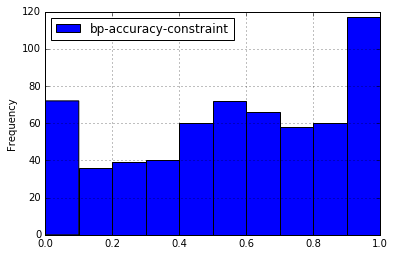

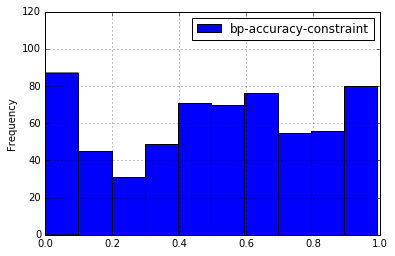

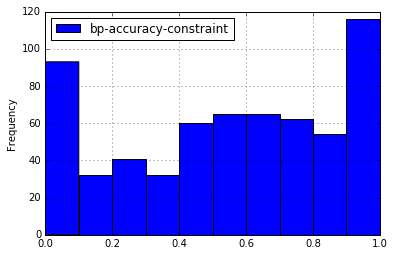

In [91]:
def plot_hist(df):
    ax=df[['bp-accuracy-constraint']].plot(kind='hist')
#     ax=df[['bp-accuracy-mfe']].plot(kind='hist') 
    ax.set_ylim([0,120])
    ax.grid()
plot_hist(df_total_turner_assym)
plot_hist(df_total_andero_assym)
plot_hist(df_total_quake_assym)


In [106]:
# df_all_appended = df_total_turner_assym.append(df_total_andero_assym).append(df_total_quake_assym)
# df_all_appended.to_csv('df_turner-andero-quake_assym.csv')
# plot_hist(df_all_appended[df_all_appended['energy-param']=='turner'])
# plot_hist(df_all_appended[df_all_appended['energy-param']=='andero'])
# plot_hist(df_all_appended[df_all_appended['energy-param']=='quake'])


In [92]:
df_total_turner_assym

,bp-accuracy-mfe,bp-accuracy-constraint,seq-id,dataset,fam-id,context-len,Asymmetric,energy-param,instance-name
instance-name,,,,,,,,,
C200-RF00023-AE004439.1/906024-905659,0.352487,0.372763,AE004439.1/906024-905659,genome,RF00023,200,True,turner,C200-RF00023-AE004439.1/906024-905659
C200-RF00023-AY129337.1/100059-100494,0.203119,0.131543,AY129337.1/100059-100494,genome,RF00023,200,True,turner,C200-RF00023-AY129337.1/100059-100494
C200-RF00023-AP006841.1/1350686-1351082,0.253286,0.288476,AP006841.1/1350686-1351082,genome,RF00023,200,True,turner,C200-RF00023-AP006841.1/1350686-1351082
C200-RF00023-CP000712.1/5154291-5154681,0.119770,0.042273,CP000712.1/5154291-5154681,genome,RF00023,200,True,turner,C200-RF00023-CP000712.1/5154291-5154681
C200-RF00023-AE000512.1/531684-532038,0.757689,0.794673,AE000512.1/531684-532038,genome,RF00023,200,True,turner,C200-RF00023-AE000512.1/531684-532038
C200-RF00023-AB003477.1/1390-1782,0.353644,0.294456,AB003477.1/1390-1782,genome,RF00023,200,True,turner,C200-RF00023-AB003477.1/1390-1782
C200-RF00023-CP000546.1/978037-978405,0.441027,0.293519,CP000546.1/978037-978405,genome,RF00023,200,True,turner,C200-RF00023-CP000546.1/978037-978405
C200-RF00023-BA000022.2/3317157-3316760,0.136723,0.118690,BA000022.2/3317157-3316760,genome,RF00023,200,True,turner,C200-RF00023-BA000022.2/3317157-3316760
C200-RF00023-AB002583.1/13544-13310,0.567747,0.727856,AB002583.1/13544-13310,genome,RF00023,200,True,turner,C200-RF00023-AB002583.1/13544-13310


In [76]:
df_total_turner_assym.median()

bp-accuracy-mfe             0.582355
bp-accuracy-constraint      0.592202
context-len               200.000000
Asymmetric                  1.000000
dtype: float64

In [25]:
df_turner_assym

,bp-accuracy,seq-id,dataset,fam-id,context-len,instance-name
instance-name,,,,,,
C200-RF00023-AE004439.1/906024-905659,0.352487,AE004439.1/906024-905659,genome,RF00023,200,C200-RF00023-AE004439.1/906024-905659
C200-RF00023-AY129337.1/100059-100494,0.203119,AY129337.1/100059-100494,genome,RF00023,200,C200-RF00023-AY129337.1/100059-100494
C200-RF00023-AP006841.1/1350686-1351082,0.253286,AP006841.1/1350686-1351082,genome,RF00023,200,C200-RF00023-AP006841.1/1350686-1351082
C200-RF00023-CP000712.1/5154291-5154681,0.119770,CP000712.1/5154291-5154681,genome,RF00023,200,C200-RF00023-CP000712.1/5154291-5154681
C200-RF00023-AE000512.1/531684-532038,0.757689,AE000512.1/531684-532038,genome,RF00023,200,C200-RF00023-AE000512.1/531684-532038
C200-RF00023-AB003477.1/1390-1782,0.353644,AB003477.1/1390-1782,genome,RF00023,200,C200-RF00023-AB003477.1/1390-1782
C200-RF00023-CP000546.1/978037-978405,0.441027,CP000546.1/978037-978405,genome,RF00023,200,C200-RF00023-CP000546.1/978037-978405
C200-RF00023-BA000022.2/3317157-3316760,0.136723,BA000022.2/3317157-3316760,genome,RF00023,200,C200-RF00023-BA000022.2/3317157-3316760
C200-RF00023-AB002583.1/13544-13310,0.567747,AB002583.1/13544-13310,genome,RF00023,200,C200-RF00023-AB002583.1/13544-13310


In [16]:
print df_total.median()
print df_total.mean()


bp-accuracy      0.627989
context-len    200.000000
Asymmetric       0.000000
dtype: float64
bp-accuracy      0.583837
context-len    200.000000
Asymmetric       0.000000
dtype: float64


In [23]:
df_quake_assym.median()

bp-accuracy      0.576135
context-len    200.000000
dtype: float64

In [169]:
import pandas as pd
# df_benchmark_all = pd.DataFrame()
# df_benchmark_all_quake = pd.DataFrame() #columns=['instance-name', 'seq-id', 'family-id', 'context-len'])
for famid in rfam_fams[0:10]:
    print "***** RFAM Family: ", famid
    for cont_len in [500]:#0 , 100, 200]:
        df_fam_scores = benchmark_family(famid, context_len=cont_len, runquake=False)
        df_benchmark_all = df_benchmark_all.append(df_fam_scores)

        df_fam_scores_quake = benchmark_family(famid, context_len=cont_len, runquake=True)
        df_benchmark_all_quake = df_benchmark_all_quake.append(df_fam_scores_quake)
    
df_benchmark_all_quake




Number of sequences in .struct:  25
/home/milad/DataBase/CisReg/Cis_include_genome2/RF00194/RF00194.filtered.clustal
Number of sequences in alignment:  25
D50677.1/1417-1484 L19420.1/1530-1597 Warning: benchmarking flanked sequnce with unknown nucleotides /home/milad/DataBase/CisReg/Cis_include_genome2/RF00194/Cis_flanks-500//L19420.1_1530-1597_unknown_nt.fasta
AB003341.1/1417-1484 AY397695.1/1417-1484 AB047330.1/9674-9741 M15240.1/9667-9734 AB003353.1/1417-1484 AF435866.1/9655-9722 AB080731.1/1417-1484 AB072383.1/1417-1484 AB072387.1/1417-1484 AB003349.1/1417-1484 AB003345.1/1417-1484 AB080733.1/1417-1484 X05259.1/3294-3361 AY280704.1/1417-1484 AB003337.1/1417-1484 AY161374.1/1390-1443 AB003355.1/1417-1484 AY258323.1/9674-9741 AB003343.1/1417-1484 D00156.1/2363-2430 AY161373.1/1390-1443 AY258322.1/9674-9741 AB080198.1/1417-1484
D00156.1/2363-2430 D00156.1_1863-2451 context_len_left 500, context_len_right 21
    TP_score: 0.65
AB080198.1/1417-1484 AB080198.1_917-1484 context_len_left 5

TypeError: object of type 'float' has no len()

In [170]:
def my_plot(df, context_len, famid='all'):
    df_selection = df[df['context-len'] == context_len]
    if famid != 'all':
        df_selection = df_selection[df_selection['fam-id']==famid]
    print len(df_selection)
    print "contextlen: ", int(df_selection.median()['context-len'])
    print "median:     %.3f" % df_selection.median()['bp-accuracy']
    print "mean:       %.3f"% df_selection.mean()['bp-accuracy']
    print
    return df_selection
desired_fam = 'all'
my_plot(df_benchmark_all, context_len=0, famid=desired_fam)
my_plot(df_benchmark_all, context_len=100, famid=desired_fam)
my_plot(df_benchmark_all, context_len=200, famid=desired_fam)
my_plot(df_benchmark_all, context_len=500, famid=desired_fam)


# df_benchmark_all.median()
    

282
contextlen:  0
median:     0.727
mean:       0.664

282
contextlen:  100
median:     0.500
mean:       0.457

282
contextlen:  200
median:     0.563
mean:       0.527

282
contextlen:  500
median:     0.501
mean:       0.481



,bp-accuracy,seq-id,fam-id,context-len,instance-name
instance-name,,,,,
C500-RF00194-M15240.1/9667-9734,0.635891,M15240.1/9667-9734,RF00194,500,C500-RF00194-M15240.1/9667-9734
C500-RF00194-AB047330.1/9674-9741,0.668492,AB047330.1/9674-9741,RF00194,500,C500-RF00194-AB047330.1/9674-9741
C500-RF00194-X05259.1/3294-3361,0.571225,X05259.1/3294-3361,RF00194,500,C500-RF00194-X05259.1/3294-3361
C500-RF00194-AB003355.1/1417-1484,0.664692,AB003355.1/1417-1484,RF00194,500,C500-RF00194-AB003355.1/1417-1484
C500-RF00194-AB003349.1/1417-1484,0.673725,AB003349.1/1417-1484,RF00194,500,C500-RF00194-AB003349.1/1417-1484
C500-RF00194-AB080731.1/1417-1484,0.639689,AB080731.1/1417-1484,RF00194,500,C500-RF00194-AB080731.1/1417-1484
C500-RF00194-D50677.1/1417-1484,0.640700,D50677.1/1417-1484,RF00194,500,C500-RF00194-D50677.1/1417-1484
C500-RF00194-D00156.1/2363-2430,0.650776,D00156.1/2363-2430,RF00194,500,C500-RF00194-D00156.1/2363-2430
C500-RF00194-AB003337.1/1417-1484,0.580462,AB003337.1/1417-1484,RF00194,500,C500-RF00194-AB003337.1/1417-1484


In [172]:
my_plot(df_benchmark_all_quake, context_len=0, famid=desired_fam)
my_plot(df_benchmark_all_quake, context_len=100, famid=desired_fam)
my_plot(df_benchmark_all_quake, context_len=200, famid=desired_fam)
my_plot(df_benchmark_all_quake, context_len=500,  famid=desired_fam)

282
contextlen:  0
median:     0.721
mean:       0.659

282
contextlen:  100
median:     0.483
mean:       0.452

282
contextlen:  200
median:     0.551
mean:       0.514

282
contextlen:  500
median:     0.488
mean:       0.468



,bp-accuracy,seq-id,fam-id,context-len,instance-name
instance-name,,,,,
C500-RF00194-M15240.1/9667-9734,0.642392,M15240.1/9667-9734,RF00194,500,C500-RF00194-M15240.1/9667-9734
C500-RF00194-AB047330.1/9674-9741,0.668756,AB047330.1/9674-9741,RF00194,500,C500-RF00194-AB047330.1/9674-9741
C500-RF00194-X05259.1/3294-3361,0.545181,X05259.1/3294-3361,RF00194,500,C500-RF00194-X05259.1/3294-3361
C500-RF00194-AB003355.1/1417-1484,0.660441,AB003355.1/1417-1484,RF00194,500,C500-RF00194-AB003355.1/1417-1484
C500-RF00194-AB003349.1/1417-1484,0.670451,AB003349.1/1417-1484,RF00194,500,C500-RF00194-AB003349.1/1417-1484
C500-RF00194-AB080731.1/1417-1484,0.630060,AB080731.1/1417-1484,RF00194,500,C500-RF00194-AB080731.1/1417-1484
C500-RF00194-D50677.1/1417-1484,0.635100,D50677.1/1417-1484,RF00194,500,C500-RF00194-D50677.1/1417-1484
C500-RF00194-D00156.1/2363-2430,0.655016,D00156.1/2363-2430,RF00194,500,C500-RF00194-D00156.1/2363-2430
C500-RF00194-AB003337.1/1417-1484,0.574499,AB003337.1/1417-1484,RF00194,500,C500-RF00194-AB003337.1/1417-1484
